# Flatness vs. Generalization pt 1

In [1]:
### Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device", device)

Device cuda


In [3]:
class model_class(nn.Module):
    def __init__(self, input_size, output_size, hidden_sizes=None):
        super(model_class, self).__init__()

        # Store model architecture parameters
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_sizes = hidden_sizes or []

        # Create layers
        layers = []
        in_features = input_size
        for h_size in hidden_sizes:
            layers.append(nn.Linear(in_features, h_size))
            layers.append(nn.ReLU())  # Add activation after each hidden layer
            in_features = h_size
        layers.append(nn.Linear(in_features, output_size))
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        # Forward pass through the layers
        x = x.view(-1, 784)
        for layer in self.layers:
            x = layer(x)
        return x

In [4]:
### training function for MNIST data set
def train_eval(model, num_epochs, learning_rate, train_loader, test_loader):
    # model to device
    model = model.to(device)
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # Training loop
    total_loss = []
    total_accuracy = []
    for epoch in range(num_epochs):
        train_loss = 0.0

        #Training
        model.train()
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            #print(images.shape, labels.shape)

            # Zero out Gradient
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            train_loss += loss * images.size(0)

        train_loss = train_loss/len(train_loader.sampler)
        total_loss.append(train_loss)

        #Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        total_accuracy.append(accuracy)
        
        print(f"Epoch {epoch}; loss: {total_loss[-1]}")
    return total_loss[-1], total_accuracy[-1]

In [5]:
# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='../data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='../data', train=False, transform=transforms.ToTensor())

# Data loaders
train_loader1 = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader1 = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# Data loaders
train_loader2 = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=1024, shuffle=True)
test_loader2 = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=1024, shuffle=False)

In [6]:
model1 = model_class(input_size = 784, output_size = 10, hidden_sizes = [32,64])
model2 = model_class(input_size = 784, output_size = 10, hidden_sizes = [32,64])

In [7]:
m1_loss, m1_acc = train_eval(model1, num_epochs=10, learning_rate=0.001, train_loader=train_loader1
                             , test_loader=test_loader1)
m2_loss, m2_acc = train_eval(model2, num_epochs=10, learning_rate=0.001, train_loader=train_loader2
                             , test_loader=test_loader2)

Epoch 0; loss: 0.4148637652397156
Epoch 1; loss: 0.1958414614200592
Epoch 2; loss: 0.1543499231338501
Epoch 3; loss: 0.12824024260044098
Epoch 4; loss: 0.10989928990602493
Epoch 5; loss: 0.09750944375991821
Epoch 6; loss: 0.0871395543217659
Epoch 7; loss: 0.07673916965723038
Epoch 8; loss: 0.07021400332450867
Epoch 9; loss: 0.06474973261356354
Epoch 0; loss: 1.461719274520874
Epoch 1; loss: 0.43163812160491943
Epoch 2; loss: 0.31925779581069946
Epoch 3; loss: 0.27857860922813416
Epoch 4; loss: 0.25483083724975586
Epoch 5; loss: 0.23473119735717773
Epoch 6; loss: 0.2186763435602188
Epoch 7; loss: 0.20373839139938354
Epoch 8; loss: 0.1908496767282486
Epoch 9; loss: 0.1791858971118927


In [8]:
alpha = torch.linspace(-1,2,50)
m1_params = torch.nn.utils.parameters_to_vector(model1.parameters())
m2_params = torch.nn.utils.parameters_to_vector(model2.parameters())
theta = []

In [9]:
for i in range(len(alpha)):
    theta.append((1-alpha[i])*m1_params + alpha[i]*m2_params)
print(len(theta))

50


In [10]:
def get_loss(model, data_loader):
    criterion = nn.CrossEntropyLoss()
    total_loss = 0.0

    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            #print(images.shape, labels.shape)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            total_loss += loss * images.size(0)

        total_loss = total_loss/len(data_loader.sampler)
    return total_loss

In [11]:
def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
    return accuracy

In [12]:
train_loss_vec = []
train_acc_vec = []
test_loss_vec = []
test_acc_vec = []
for i in range(len(theta)):
    model = model_class(input_size = 784, output_size = 10, hidden_sizes = [32,64])
    torch.nn.utils.vector_to_parameters(theta[i], model.parameters())
    train_loss = get_loss(model, train_loader1)
    train_acc = get_accuracy(model, train_loader1)
    test_loss = get_loss(model, test_loader1)
    test_acc = get_accuracy(model, test_loader1)
    train_loss_vec.append(train_loss)
    train_acc_vec.append(train_acc)
    test_loss_vec.append(test_loss)
    test_acc_vec.append(test_acc)

In [13]:
train_loss_vec1 = np.array([x.detach().cpu().numpy() for x in train_loss_vec])
test_loss_vec1 = np.array([x.detach().cpu().numpy() for x in test_loss_vec])

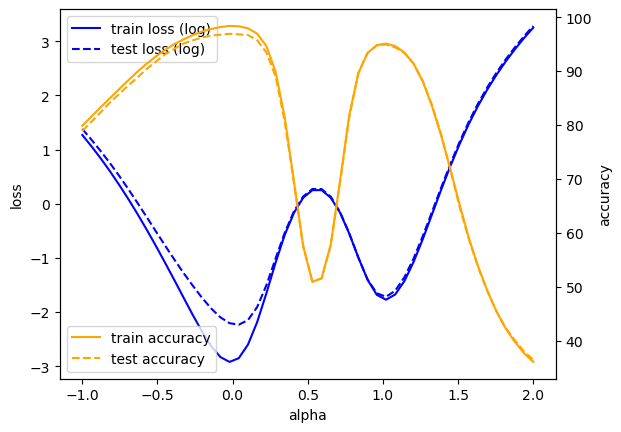

In [14]:
plt.plot(alpha.detach().numpy(), np.log(train_loss_vec1), label = "train loss (log)", color = "blue")
plt.plot(alpha.detach().numpy(), np.log(test_loss_vec1), label = "test loss (log)", color = "blue", linestyle = "dashed")
plt.legend()
plt.xlabel("alpha")
plt.ylabel("loss")
plt.twinx()
plt.plot(alpha.detach().numpy(), train_acc_vec, label = "train accuracy", color = "orange")
plt.plot(alpha.detach().numpy(), test_acc_vec, label = "test accuracy", color = "orange", linestyle = "dashed")
plt.legend()
plt.xlabel("alpha")
plt.ylabel("accuracy")
plt.savefig("flat_v_gen_p1.png")
plt.show()